# HW3
Using any dataset you like (MNIST or similar is recommended so you can iterate quickly), design and run experiments to compare:
1. Three different learning rates.
2. Three different ​activations​.
   
3. Three different ​optimizers​.
4. Three different ​weight initialization strategies​.
For each experiment, please:

● Visualize your results with TensorBoard (and include a screenshot with your submission).

● Include a brief write up (two paragraphs give or take) summarizing your findings. 

Are the results what you expected? Why or why not?


In [0]:
!pip install -q tf-nightly-2.0-preview
# Load the TensorBoard notebook extension
%load_ext tensorboard.notebook

The tensorboard.notebook extension is already loaded. To reload it, use:
  %reload_ext tensorboard.notebook


In [0]:
!rm -rf ./logs/

In [0]:
import datetime
import tensorflow as tf
import os

# Imports for the HParams plugin
from tensorboard.plugins.hparams import api_pb2
from tensorboard.plugins.hparams import summary as hparams_summary
from google.protobuf import struct_pb2

In [0]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

## Setting hyperparameter

In [0]:
learning_rate_list = [1e-6, 1e-4, 1e-2, 1e-1]
activations_list = ['relu', 'sigmoid', 'linear']
optimizer_list = ['adam', 'sgd', 'RMSprop']
initialization_list = ['RandomUniform', 'Zeros', 'RandomNormal']

In [0]:
def create_experiment_summary(learning_rate_list, activations_list, optimizer_list, initialization_list):
    learning_rate_list_val = struct_pb2.ListValue()
    learning_rate_list_val.extend(learning_rate_list)
    
    activations_list_val = struct_pb2.ListValue()
    activations_list_val.extend(activations_list)
    
    optimizer_list_val = struct_pb2.ListValue()
    optimizer_list_val.extend(optimizer_list)
    
    initialization_list_val = struct_pb2.ListValue()
    initialization_list_val.extend(initialization_list)

    return hparams_summary.experiment_pb(
      # The hyperparameters being changed
      hparam_infos=[
          api_pb2.HParamInfo(name='learning_rate',
                             display_name='learning_rate',
                             type=api_pb2.DATA_TYPE_FLOAT64,
                             domain_discrete=learning_rate_list_val),
          api_pb2.HParamInfo(name='activations',
                             display_name='Activations',
                             type=api_pb2.DATA_TYPE_FLOAT64,
                             domain_discrete=activations_list_val),
          api_pb2.HParamInfo(name='optimizer',
                             display_name='Optimizer',
                             type=api_pb2.DATA_TYPE_STRING,
                             domain_discrete=optimizer_list_val),
          api_pb2.HParamInfo(name='initialization',
                             display_name='Initialization',
                             type=api_pb2.DATA_TYPE_STRING,
                             domain_discrete=initialization_list_val)
      ],
      # The metrics being tracked
      metric_infos=[
          api_pb2.MetricInfo(
              name=api_pb2.MetricName(
                  tag='accuracy'),
              display_name='Accuracy'),
      ]
    )

exp_summary = create_experiment_summary(learning_rate_list, activations_list, optimizer_list, initialization_list)
root_logdir_writer = tf.summary.create_file_writer("logs/hparam_tuning")

with root_logdir_writer.as_default():
    tf.summary.import_event(tf.compat.v1.Event(summary=exp_summary).SerializeToString())

In [0]:
def train_test_model(hparams):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=hparams['activations'], kernel_initializer=hparams['initialization']),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
        ])
    model.compile(optimizer=tf.optimizers.Adam(hparams['learning_rate']),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    model.fit(x_train, y_train, epochs=5) # Run with 1 epoch to speed things up for demo purposes
    _, accuracy = model.evaluate(x_test, y_test)
    return accuracy

In [0]:
def run(run_dir, hparams):
    writer = tf.summary.create_file_writer(run_dir)
    summary_start = hparams_summary.session_start_pb(hparams=hparams)

    with writer.as_default():
        accuracy = train_test_model(hparams)
        summary_end = hparams_summary.session_end_pb(api_pb2.STATUS_SUCCESS)

        tf.summary.scalar('accuracy', accuracy, step=1, description="The accuracy")
        tf.summary.import_event(tf.compat.v1.Event(summary=summary_start).SerializeToString())
        tf.summary.import_event(tf.compat.v1.Event(summary=summary_end).SerializeToString())

# 1. Three different learning rate

In [0]:
session_num = 0

for learning_rate in learning_rate_list:
    for activations in ['relu']:
        for initializer in ['RandomNormal']:
            hparams = {'learning_rate': learning_rate, 'activations': activations,'initialization': initializer}
            print('--- Running training session %d' % (session_num + 1))
            print(hparams)
            run_name = "run-%d" % session_num
            run("logs/hparam_tuning/" + run_name, hparams)
            session_num += 1

--- Running training session 1
{'learning_rate': 1e-06, 'activations': 'relu', 'initialization': 'RandomNormal'}
Epoch 1/5
60000/60000 [==============================] - 5s 88us/sample - loss: 2.2393 - accuracy: 0.1659
Epoch 2/5
60000/60000 [==============================] - 5s 86us/sample - loss: 1.9500 - accuracy: 0.3452
Epoch 3/5
60000/60000 [==============================] - 5s 86us/sample - loss: 1.7213 - accuracy: 0.4808
Epoch 4/5
60000/60000 [==============================] - 5s 86us/sample - loss: 1.5348 - accuracy: 0.5817
Epoch 5/5
10000/10000 [==============================] - 0s 50us/sample - loss: 1.3340 - accuracy: 0.6366
--- Running training session 2
{'learning_rate': 0.0001, 'activations': 'relu', 'initialization': 'RandomNormal'}
Epoch 1/5
60000/60000 [==============================] - 5s 90us/sample - loss: 0.6998 - accuracy: 0.7764
Epoch 2/5
60000/60000 [==============================] - 5s 85us/sample - loss: 0.4758 - accuracy: 0.8395
Epoch 3/5
60000/60000 [========

In [0]:
%tensorboard --logdir logs/hparam_tuning

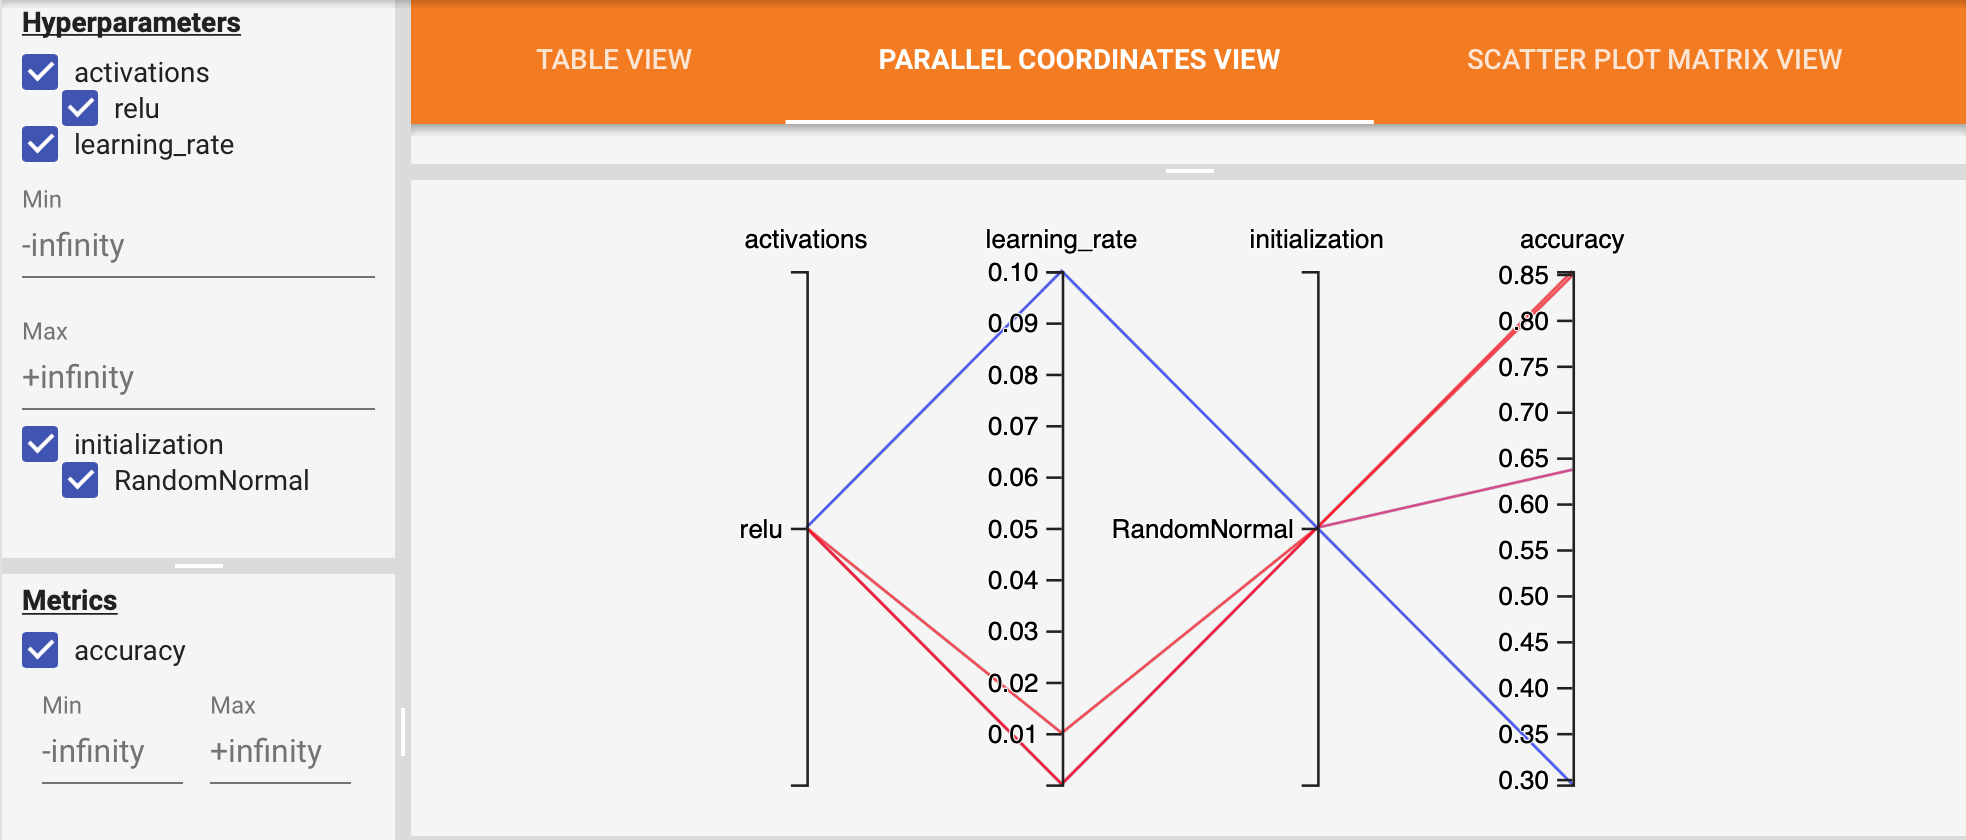

In [0]:
from IPython.display import Image
Image('WX20190314-230709@2x.png', width=900, height=400)

## Conclusion on learning rates


* For every optimizer, the majority of learning rates fail to train the model.

* There is a valley shape for each optimizer: too low a learning rate never progresses, and too high a learning rate causes instability and never converges. In between, there is a band of “just right” learning rates that successfully train.

* There is no learning rate that works for all optimizers.

* Learning rate can affect training time by an order of magnitude.

# 2. Three different ​activations​.

In [0]:
!rm -rf ./logs/

In [0]:
session_num = 0

for learning_rate in [1e-2]:
    for activations in activations_list:
        for initializer in ['RandomNormal']:
          hparams = {'learning_rate': learning_rate, 'activations': activations,'initialization': initializer}
          print('--- Running training session %d' % (session_num + 1))
          print(hparams)
          run_name = "run-%d" % session_num
          run("logs/hparam_tuning/" + run_name, hparams)
          session_num += 1

--- Running training session 1
{'learning_rate': 0.01, 'activations': 'relu', 'initialization': 'RandomNormal'}
Epoch 1/5
60000/60000 [==============================] - 5s 85us/sample - loss: 0.5330 - accuracy: 0.8130
Epoch 2/5
60000/60000 [==============================] - 5s 84us/sample - loss: 0.4392 - accuracy: 0.8444
Epoch 3/5
60000/60000 [==============================] - 5s 85us/sample - loss: 0.4144 - accuracy: 0.8522
Epoch 4/5
60000/60000 [==============================] - 5s 83us/sample - loss: 0.4093 - accuracy: 0.8536
Epoch 5/5
10000/10000 [==============================] - 0s 48us/sample - loss: 0.4456 - accuracy: 0.8536
--- Running training session 2
{'learning_rate': 0.01, 'activations': 'sigmoid', 'initialization': 'RandomNormal'}
Epoch 1/5
60000/60000 [==============================] - 8s 132us/sample - loss: 0.5321 - accuracy: 0.8076
Epoch 2/5
60000/60000 [==============================] - 5s 86us/sample - loss: 0.4678 - accuracy: 0.8317
Epoch 3/5
60000/60000 [=======

In [0]:
%tensorboard --logdir logs/hparam_tuning

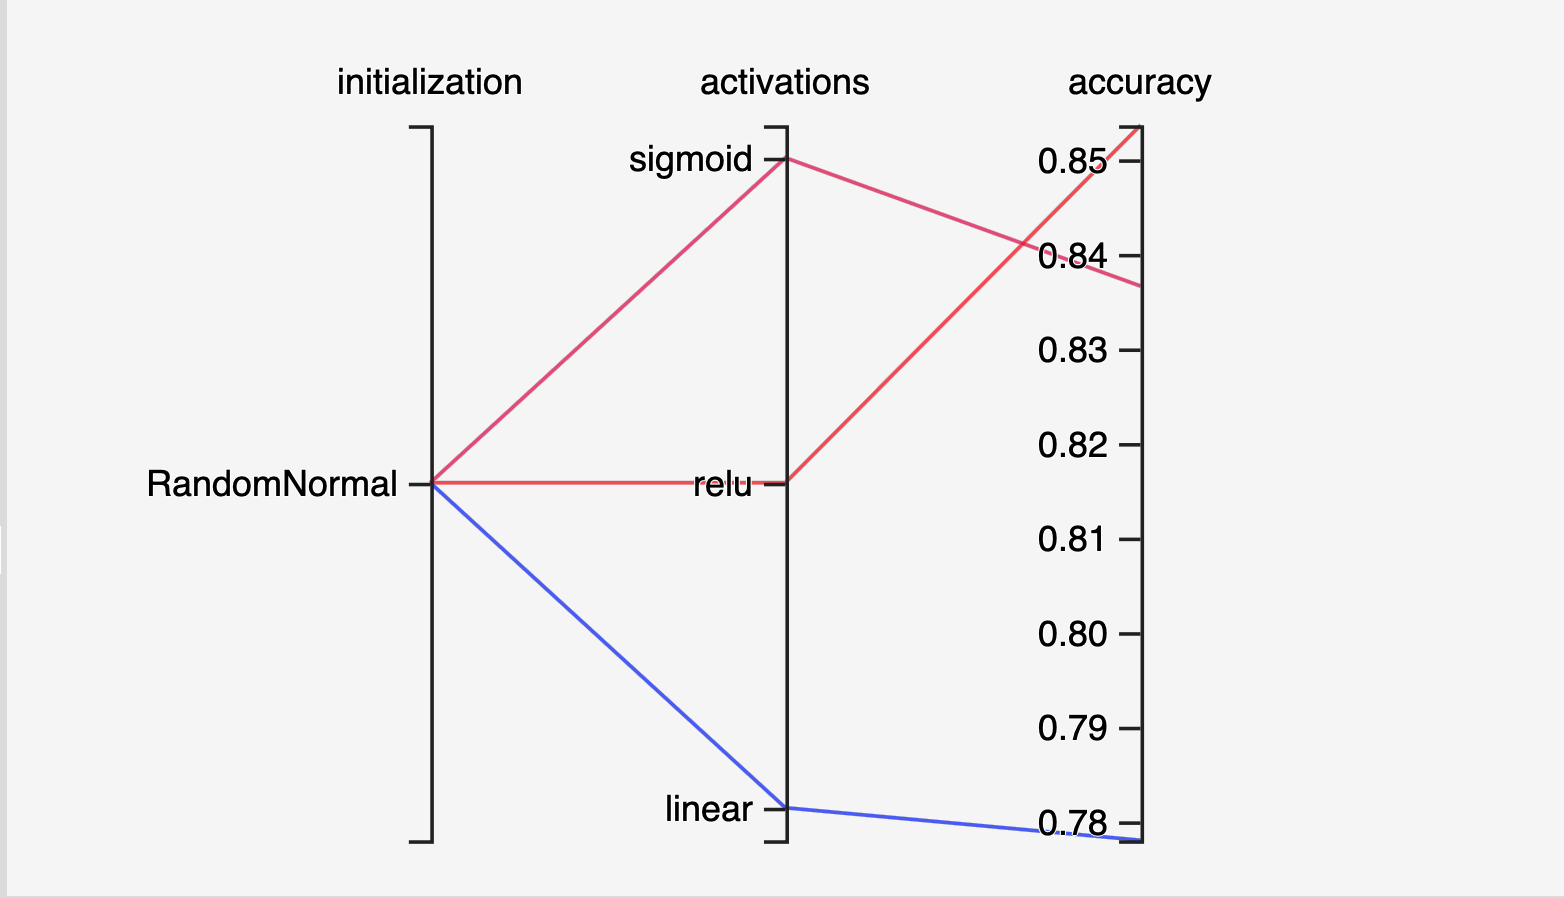

In [0]:
from IPython.display import Image
Image('WX20190314-231550@2x.png', width=800, height=500)

## Conclusion on different activation function

* each of these activate function can be trained
* the accuracy may different, but they affected little in fashion_minist except linear is not good
* the training speed of each activation is different

# 3. Three different ​optimizers​.

In [0]:
!rm -rf ./logs/

In [0]:
def train_test_model(hparams):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=hparams['activations'], kernel_initializer=hparams['initialization']),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
        ])
    model.compile(optimizer=hparams['optimizer'],
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    model.fit(x_train, y_train, epochs=5) # Run with 1 epoch to speed things up for demo purposes
    _, accuracy = model.evaluate(x_test, y_test)
    return accuracy

In [0]:
session_num = 0

for learning_rate in [1e-2]:
    for activations in ['relu']:
        for initializer in ['RandomNormal']:
            for optimizer in optimizer_list:
                hparams = {'learning_rate': learning_rate, 'activations': activations,'initialization': initializer, 'optimizer':optimizer}
                print('--- Running training session %d' % (session_num + 1))
                print(hparams)
                run_name = "run-%d" % session_num
                run("logs/hparam_tuning/" + run_name, hparams)
                session_num += 1

--- Running training session 1
{'learning_rate': 0.01, 'activations': 'relu', 'initialization': 'RandomNormal', 'optimizer': 'adam'}
Epoch 1/5
60000/60000 [==============================] - 5s 90us/sample - loss: 0.5009 - accuracy: 0.8243
Epoch 2/5
60000/60000 [==============================] - 5s 88us/sample - loss: 0.3768 - accuracy: 0.8643
Epoch 3/5
60000/60000 [==============================] - 5s 88us/sample - loss: 0.3351 - accuracy: 0.8786
Epoch 4/5
60000/60000 [==============================] - 5s 89us/sample - loss: 0.3133 - accuracy: 0.8858
Epoch 5/5
10000/10000 [==============================] - 0s 47us/sample - loss: 0.3617 - accuracy: 0.8686
--- Running training session 2
{'learning_rate': 0.01, 'activations': 'relu', 'initialization': 'RandomNormal', 'optimizer': 'sgd'}
Epoch 1/5
60000/60000 [==============================] - 5s 78us/sample - loss: 1.4030 - accuracy: 0.5790
Epoch 2/5
60000/60000 [==============================] - 5s 76us/sample - loss: 0.8679 - accuracy: 

In [0]:
%tensorboard --logdir logs/hparam_tuning

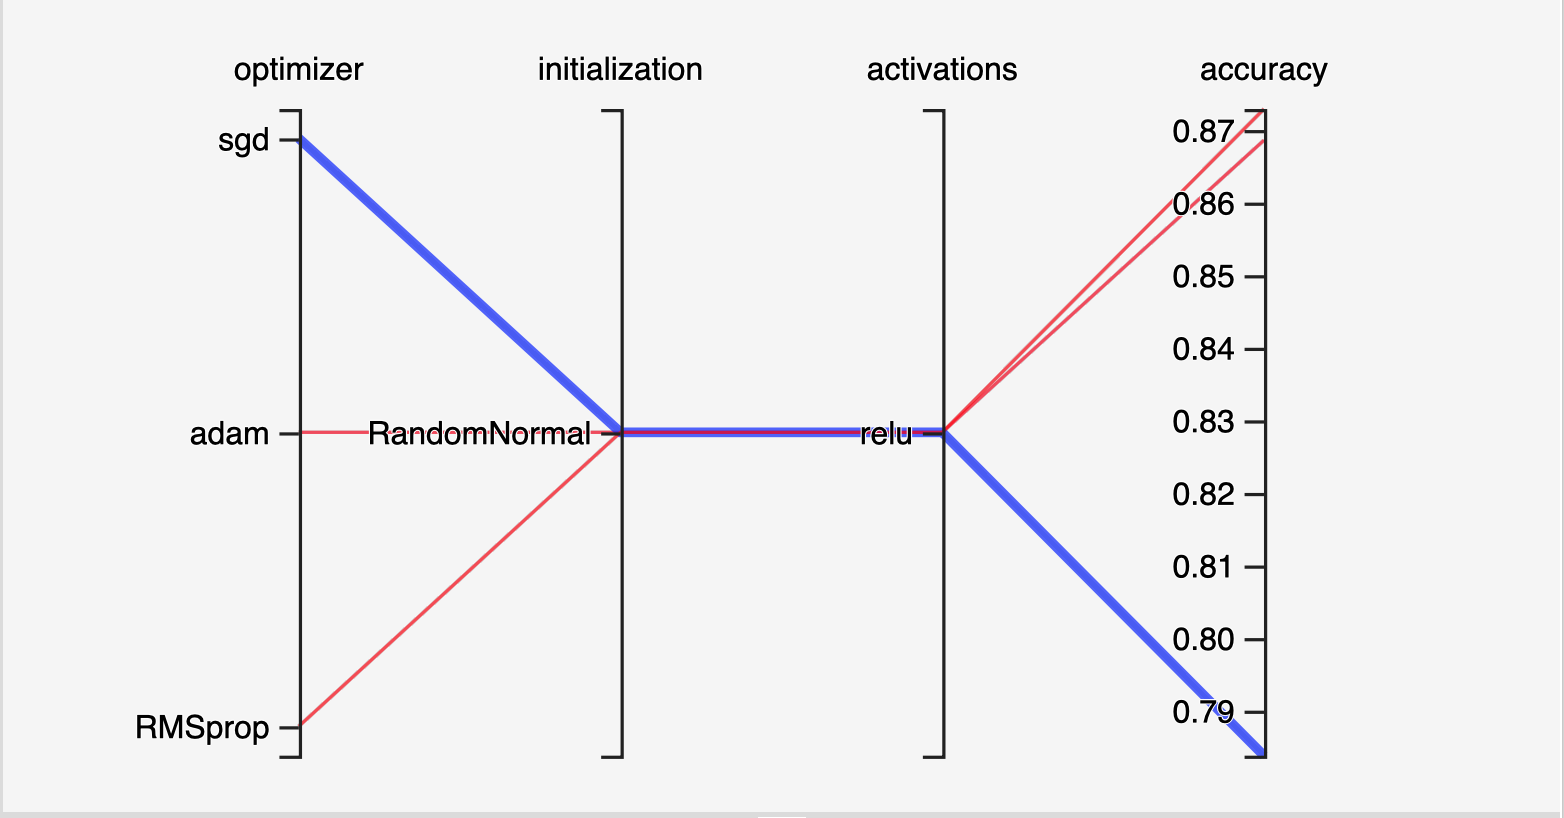

In [0]:
from IPython.display import Image
Image('WX20190314-232102@2x.png', width=800, height=400)

## conclusion on optimizer

* different optimizer accutrally affect the accuracy and training speed
* adam and RMSprop are great because they have adaptive learning rate, 
* sgd converges slow, because it is use random gradient

# 4. Three different ​weight initialization strategies​. For each experiment, please:

In [0]:
!rm -rf ./logs/

In [0]:
session_num = 0

for learning_rate in [1e-2]:
    for activations in ['linear', 'relu']:
        for initializer in initialization_list:
            for optimizer in ['adam']:
              hparams = {'learning_rate': learning_rate, 'activations': activations,'initialization': initializer, 'optimizer':optimizer}
              print('--- Running training session %d' % (session_num + 1))
              print(hparams)
              run_name = "run-%d" % session_num
              run("logs/hparam_tuning/" + run_name, hparams)
              session_num += 1

--- Running training session 1
{'learning_rate': 0.01, 'activations': 'linear', 'initialization': 'Zeros', 'optimizer': 'adam'}
Epoch 1/5
60000/60000 [==============================] - 5s 90us/sample - loss: 0.5328 - accuracy: 0.8146
Epoch 2/5
60000/60000 [==============================] - 5s 89us/sample - loss: 0.4553 - accuracy: 0.8421
Epoch 3/5
60000/60000 [==============================] - 5s 87us/sample - loss: 0.4424 - accuracy: 0.8445
Epoch 4/5
60000/60000 [==============================] - 5s 86us/sample - loss: 0.4298 - accuracy: 0.8494
Epoch 5/5
10000/10000 [==============================] - 0s 47us/sample - loss: 0.4502 - accuracy: 0.8400
--- Running training session 2
{'learning_rate': 0.01, 'activations': 'linear', 'initialization': 'RandomNormal', 'optimizer': 'adam'}
Epoch 1/5
60000/60000 [==============================] - 5s 89us/sample - loss: 0.5399 - accuracy: 0.8117
Epoch 2/5
60000/60000 [==============================] - 5s 87us/sample - loss: 0.4575 - accuracy: 0.

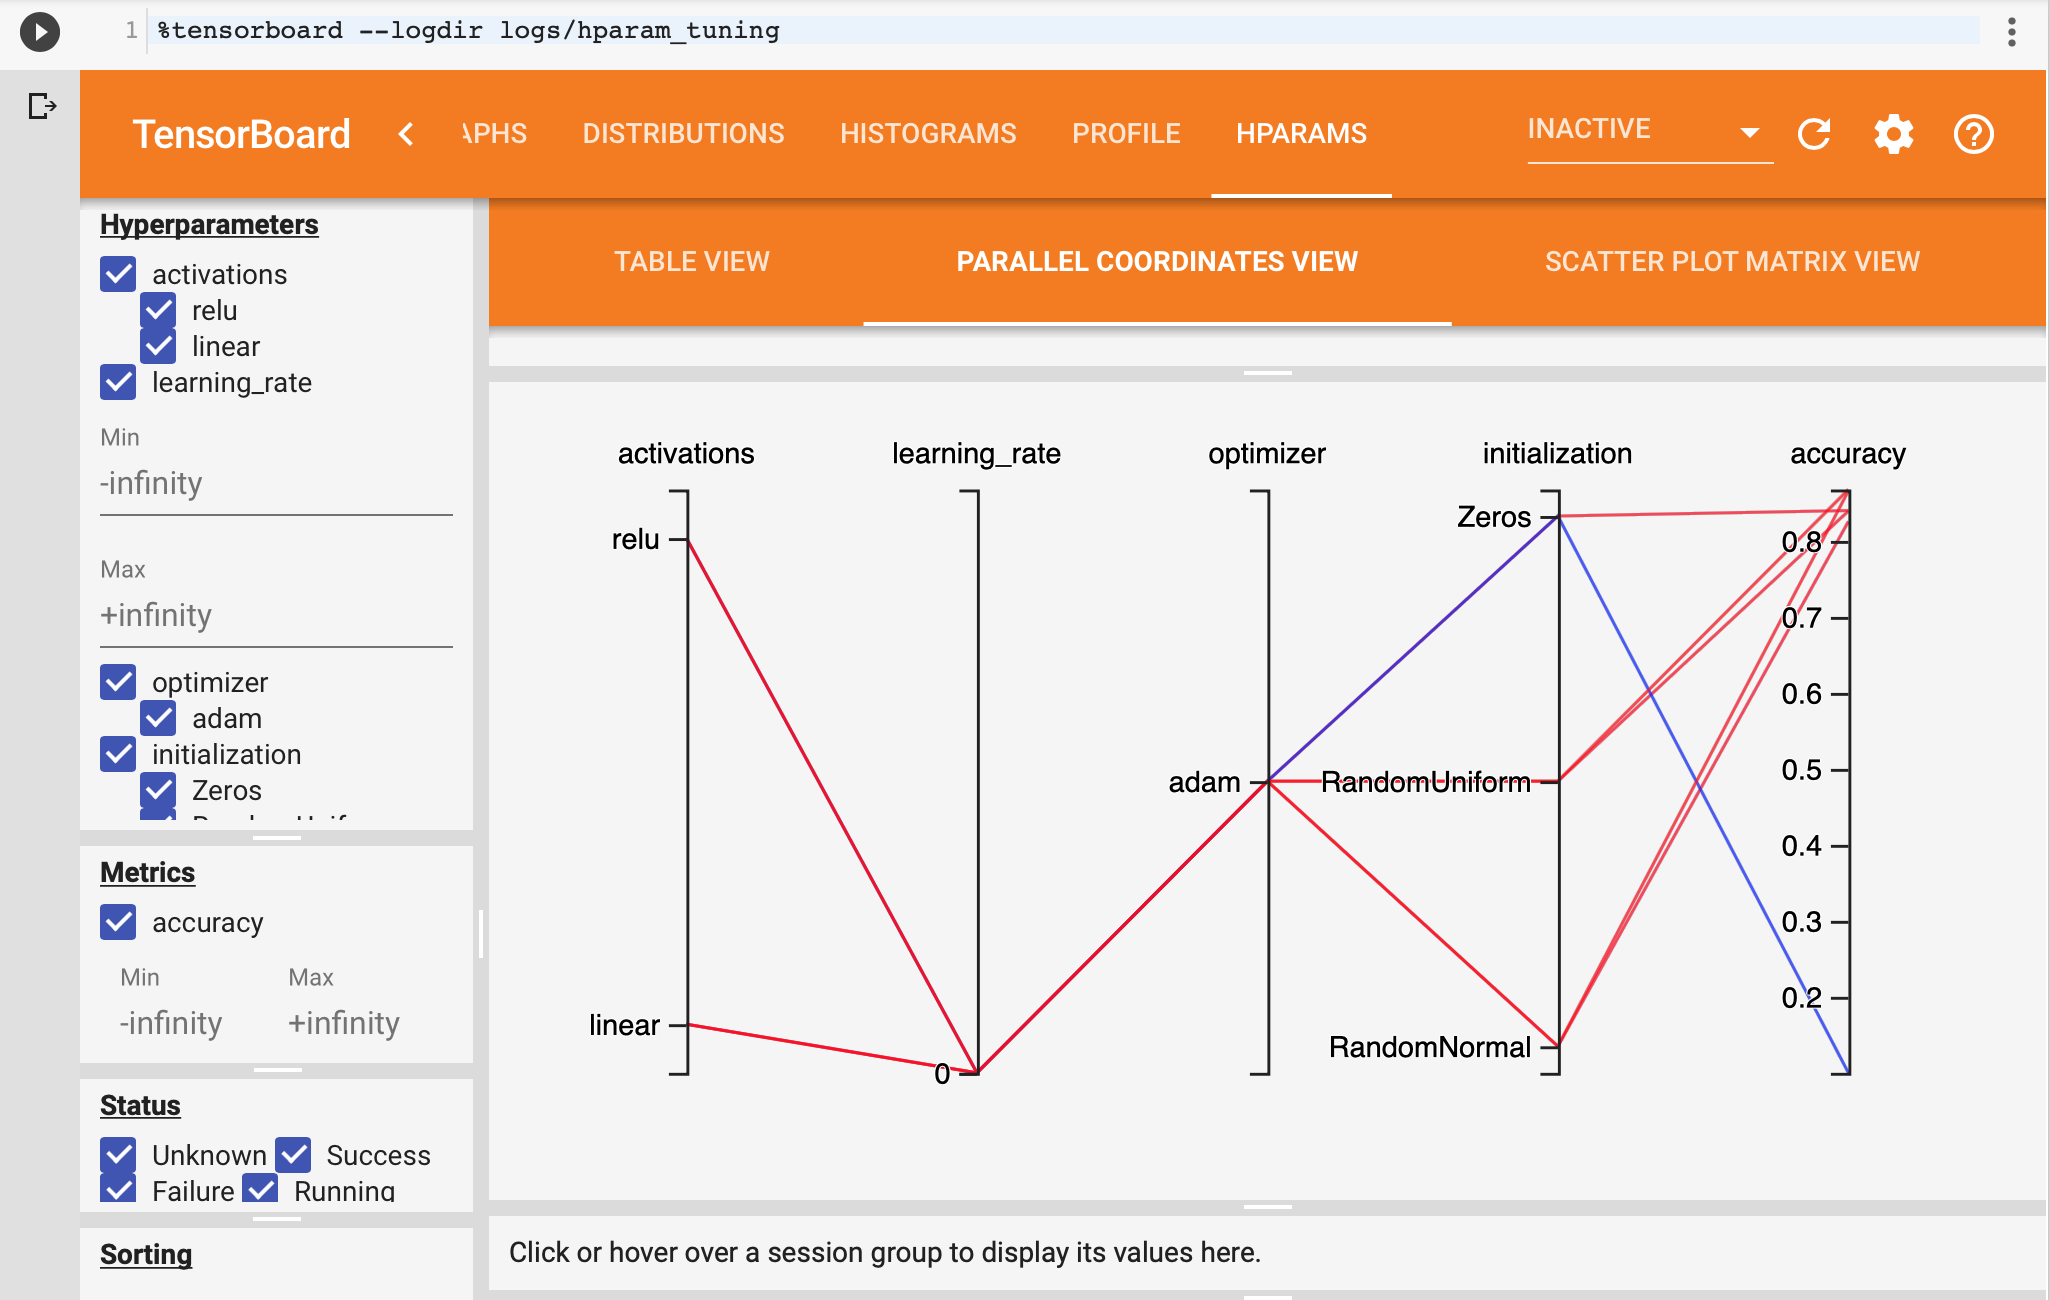

In [0]:
from IPython.display import Image
Image('WX20190314-224815@2x.png', width=800, height=500)

## conclusion

* when we use Zeros in relu, the model does't progress. This is because we can not get derivatives at 0 in relu. Relu is not derivable at 0.  So we can not use zeros initializer in Relu

* When I use Zeros in linear activation, the model converges.

* RamdomUniform and RandomNormal does not affect the training. 